In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
from sklearn.tree import export_graphviz
import graphviz
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import matplotlib as mpl
import statsmodels.formula.api as smf
import pydotplus
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

In [43]:
import os
os.chdir("/home/piai/문서/2. Big Data 분석")
os.getcwd()
df_raw = pd.read_csv("./Concrete.csv", encoding = 'euc=kr')
df_raw.head()

,cement,blast_furnace_slag,fly_ash,water,superplasticizer,coarse_aggregate,fine_aggregate,age,strength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30


In [44]:
df_raw.columns

Index(['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age', 'strength'],
      dtype='object')

Y : 목표변수, 연속형, 당뇨 발병확률

AGE :연속형, 나이

GENDER : 연속형 남성 = 1, 여성 = 2

BMI : 연속형 bmi지수

BP : 연속형, 혈압

CHOLESTREROL : 연속형, 총 콜레스트롤
LDL, HDL, TCH, LTG, GLUCOSE 

#### 2. 변수 간의 경향성 파악 : 그래프 분석

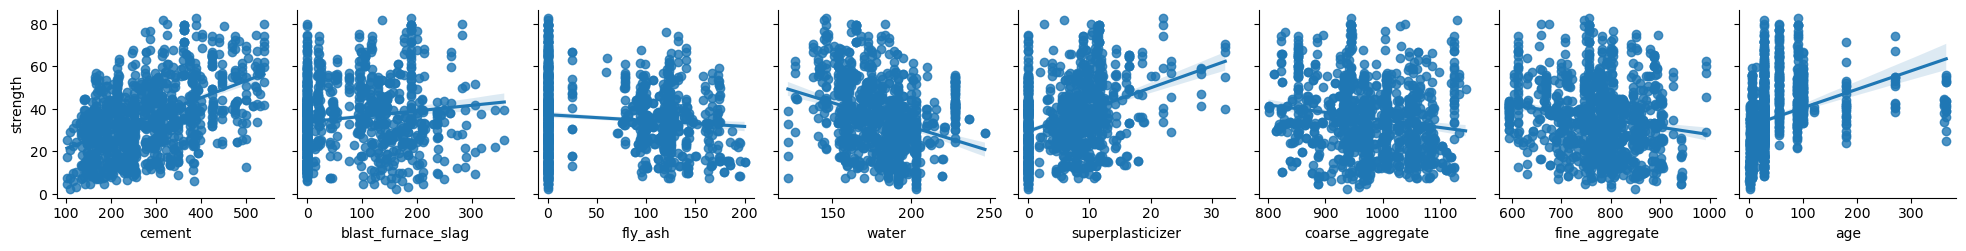

In [45]:
# 산점도 행렬 : 목표변수와 설명변수 지정
sns.pairplot(df_raw, y_vars = 'strength', x_vars = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age'], kind = 'reg')

In [46]:
#sns.pairplot(df_raw, y_vars = 'Y', x_vars = ['LDL','HDL','TCH','LTG','GLUCOSE'], kind = 'reg')

In [47]:
# 산점도 행렬
#sns.pairplot(df_raw)

In [48]:
#df_raw.corr().round(2)

#### 3. 회귀모델 생성

모델의 적합성 검토 : 분석분선 확인 / 결정게수 확인

회귀계수 유의성 검토(표준화 회귀계수 포함)

다중공산성 검토

In [49]:
# train, test data 분리
df_train, df_test = train_test_split(df_raw, test_size = 0.3, random_state = 1234)
print("train data size: {}".format(df_train.shape))
print("test data size: {}".format(df_test.shape))

train data size: (721, 9)
test data size: (309, 9)


In [50]:
#선형 회귀 분석 이용+ 상소항 자동추기
reg_model = smf.ols(formula = " strength ~ cement +  blast_furnace_slag +  fly_ash +  water +  superplasticizer +\
        coarse_aggregate +  fine_aggregate +  age ",data=df_train)

# 적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.619
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     144.7
Date:                Sun, 21 May 2023   Prob (F-statistic):          9.94e-144
Time:                        22:02:02   Log-Likelihood:                -2714.7
No. Observations:                 721   AIC:                             5447.
Df Residuals:                     712   BIC:                             5489.
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -55.7671     34

1. No. observations :309 / Df Residuals(잔차 자유도) :299 / Df Model(모델 자유도) : 10과

2. 분산분석결과 : p값이 유의수준 0.05보다 작으므로 회귀모델로서 유의하다

3. 설명력 : Adj. R-squred값이 0.511로 이 모델로 y의 51%정도 설명할 수 있다.

4. 회귀계수 검정 : BMI, BP, LTG, GENDER1의 p값이 유의수준보다 작으므로 유의하다

In [51]:
import statsmodels.api
from statsmodels.api import qqplot, add_constant
# 설명변수간의 다중공산성 확인 : 설명변수 데이터 생성 및 상수항 추가
df_train_x = df_train.drop('strength', axis = 1)

# statsmodels 의 상수항 추가 함수 적용
df_train_x_const = add_constant(df_train_x)

# DataFrame으로 저장
df_vif = pd.DataFrame()
df_vif["variable"] = df_train_x_const.columns
df_vif['VIF'] = [variance_inflation_factor(df_train_x_const.values,i)
                for i in range(df_train_x_const.shape[1])]

# vif 정렬
df_vif.sort_values("VIF", ascending=True).round(2)

,variable,VIF
8,age,1.12
5,superplasticizer,3.08
6,coarse_aggregate,5.34
3,fly_ash,6.60
4,water,7.80
7,fine_aggregate,7.94
2,blast_furnace_slag,7.97
1,cement,8.08
0,const,7550.34


VIF란, Variance Inflation Factor의 약자로서, 분산 팽창 인수라고 한다. 

이 값은 다중회귀분석에서 독립변수가 다중 공산성(Multicollnearity)의 문제를 갖고 있는지 판단하는 기준이며, 

주로 10보다 크면 그 독립변수는 다중공산성이 있다고 말한다

CHOLESTEROL이 60.66으로 매우 크므로 제거

자유도, 결정계수, 회귀계수, 검정통계량, 유의확률 확인하기

콜레스트롤을 제거하고 나니 모든 변수의 vif값이 전체적으로 줄어들었다

=> 다중공산성 해결

<Axes: >

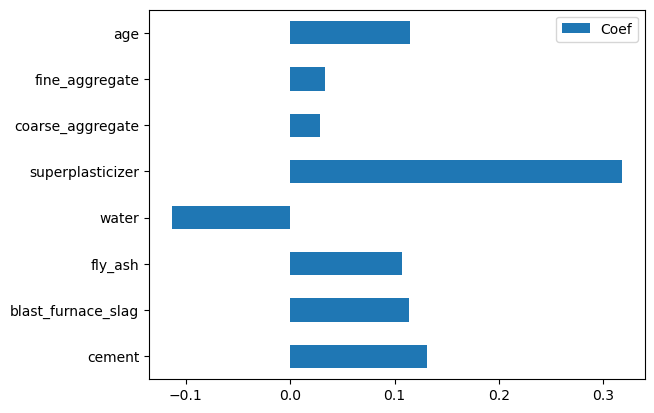

In [52]:
# 설명변수 중요도
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                          index = ['cement', 'blast_furnace_slag', 'fly_ash', 'water', 'superplasticizer',
       'coarse_aggregate', 'fine_aggregate', 'age'])
df_reg_coef.plot.barh(y = "Coef")

p-value가 0.05보다 적은 변수들만 도출 

남은 변수 :GENDER1, BP, HDL, BMI, LTG  

모든 변수의 vif가 10보다 작아졌다 => 다중공산성 해결

> 잔차의 가정 확인

- 등분산성 검정

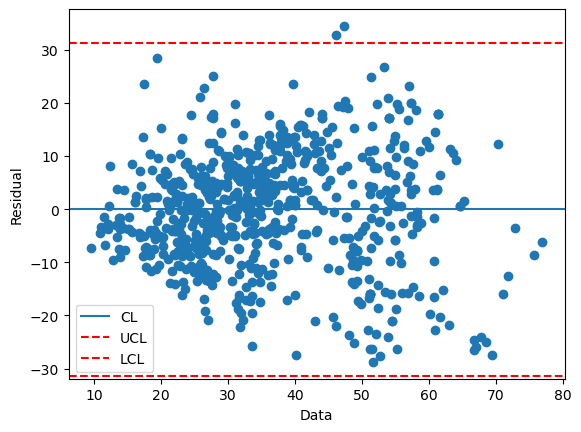

In [53]:
# 회귀 모델 잔차의 가정 확인
import numpy as np
#잔차 산점도: X  - 예측값, Y - 잔차
plt.scatter(reg_result.fittedvalues, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0, linestyle='-', label='CL')
plt.axhline(y=3*np.std(reg_result.resid), linestyle='--', color = 'red', label='UCL')
plt.axhline(y=-3*np.std(reg_result.resid), linestyle='dashed', color = 'red', label='LCL')
plt.legend()
plt.show()

잔차가 0을 기준으로 random하게 산포되어 있으므로 등분산성을 만족한다.

- 정규성 검정

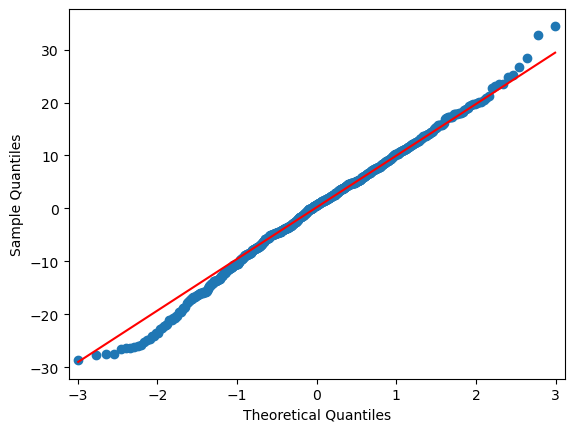

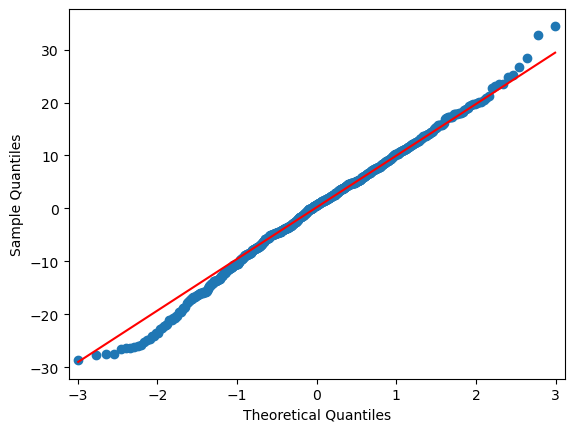

In [54]:
# 잔차 정규성 검정 qqplot, s-standardized line,
qqplot(reg_result.resid, line='q')

정규분포 직선(적색 선)을 중심으로 분포하므로 정규분포를 따른다. 

- 독립성 검정

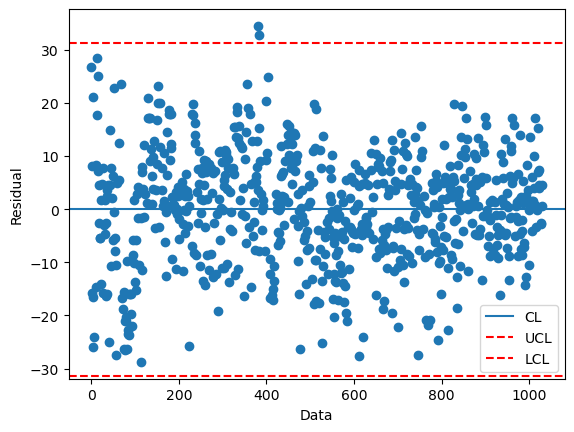

In [55]:
# 잔차의 독립성 확인
plt.scatter(df_train.index, reg_result.resid)
plt.xlabel("Data")
plt.ylabel("Residual")
plt.axhline(y=0,linestyle="-",label="CL")
plt.axhline(y=3*np.std(reg_result.resid),linestyle="--",color="red",label="UCL")
plt.axhline(y=-3*np.std(reg_result.resid),linestyle="dashed",color="red",label="LCL")
plt.legend()

잔차가 0을 기준으로 관리상하한을 벗어나지 않고, random하게 산포되어 있으므로 독립성을 만족한다

> 모델의 성능 확인

In [56]:
train_pred = reg_result.predict(df_train)
test_pred = reg_result.predict(df_test)
print("train data의 결정계수: ",r2_score(df_train["strength"],train_pred))
print("test data의 결정계수: ",r2_score(df_test["strength"],test_pred))

train data의 결정계수:  0.6191805821765541
test data의 결정계수:  0.6004271385915774


train data의 결정계수는 75.1%

test data의 결정계수는 65.8%

> 모델의 성능

In [57]:
#RFE 함수 : 입력된 모델을 이용하여 변수중요도가 낮은 순으로 순차적으로 제거
#목표변수, 설명변수 분리
df_train_y = df_train["strength"]
df_train_x = df_train.drop("strength",axis=1)

# sklearn의 선형회귀 모델
model = LinearRegression()

# 전체 변수 중 5개가 남을 때까지 선택
rfe = RFE(estimator= model, n_features_to_select=5).fit(df_train_x,df_train_y)

# 선택된 변수
selected_cols = df_train_x.columns[rfe.support_]

# 제거된 변수
removed_cols = df_train_x.columns[~rfe.support_]

print("Selected Variables : {}".format(selected_cols))
print("removed Variables : {}".format(removed_cols))

Selected Variables : Index(['cement', 'blast_furnace_slag', 'water', 'superplasticizer', 'age'], dtype='object')
removed Variables : Index(['fly_ash', 'coarse_aggregate', 'fine_aggregate'], dtype='object')


> 후진제거법을 이용한 변수 선택 및 모델 생성

In [58]:
# 회귀 모델 생성
reg_model = smf.ols(formula = " strength ~ cement +  blast_furnace_slag +  water +  superplasticizer +  age ",data=df_train)
#적합
reg_result = reg_model.fit()
print(reg_result.summary())

                            OLS Regression Results                            
Dep. Variable:               strength   R-squared:                       0.581
Model:                            OLS   Adj. R-squared:                  0.578
Method:                 Least Squares   F-statistic:                     198.5
Date:                Sun, 21 May 2023   Prob (F-statistic):          1.62e-132
Time:                        22:02:03   Log-Likelihood:                -2748.9
No. Observations:                 721   AIC:                             5510.
Df Residuals:                     715   BIC:                             5537.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             35.3479      5

1. No. observations :309 / Df Residuals(잔차 자유도) :303 / Df Model(모델 자유도) : 5

2. 분산분석결과 : p값이 유의수준 0.05보다 작으므로 회귀모델로서 적합

3. 설명력 : Adj. R-squared = 0.494 이므로 이 모델을 통해서 y를 49%만큼 설명할 수 ㅇㅆ다.

4. 회귀계수 검정 : 절편을 제외하고, TCH는 p값이 0.05보다 크므로 유의하지 않음

BMI, BP, TCH, LTG, GENDER1 가 선택됨

이전 수작업으로 선택한 변수 : GENDER1, BP, HDL, BMI, LTG
 
 * 수작업으로 변수 선택한 내용과 다르다!

#### 4. 결론 도출

* 비표준화 회귀계수 기준, 수작업 모델링 결과 적용

<Axes: >

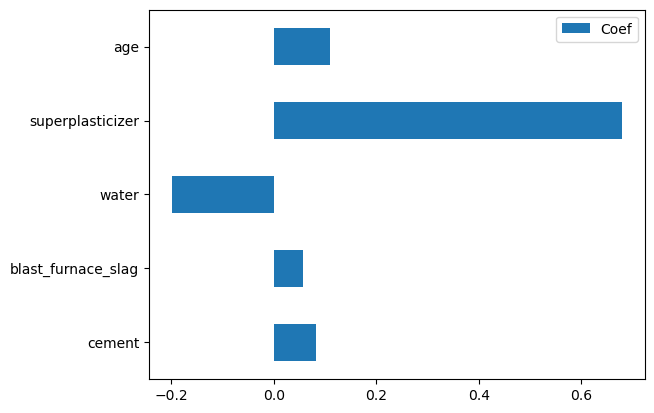

In [59]:
# 설명변수 중요도
df_reg_coef = pd.DataFrame({"Coef": reg_result.params.values[1:]},
                          index = ['cement', 'blast_furnace_slag', 'water', 'superplasticizer', 'age'])
df_reg_coef.plot.barh(y = "Coef")